In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
ds = pd.read_csv('student_loan_data.csv')
print(ds.shape)
ds.head()

(8185, 19)


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID,Processed Complaint
0,2023-12-07,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Problem with customer service,In took 1 quarter at XXXX XXXX. In that quarte...,Company believes it acted appropriately as aut...,MOHELA,OH,457XX,NaN,Consent provided,Web,2023-12-07,Closed with explanation,Yes,NaN,7958117,took quarter xxxx xxxx. quarter subsidized loa...
1,2023-12-29,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Trouble with how payments are being handled,My student loan provider is currently Nelnet. ...,NaN,"Nelnet, Inc.",IA,50265,NaN,Consent provided,Web,2023-12-29,Closed with explanation,Yes,NaN,8080675,student loan provider currently nelnet. making...
2,2023-11-13,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Received bad information about your loan,on XX/XX/25 I went to student aid.gov and appl...,NaN,"Maximus Federal Services, Inc.",CA,955XX,NaN,Consent provided,Web,2023-11-13,Closed with explanation,Yes,NaN,7844168,xx/xx/ went student aid.gov applied save progr...
3,2023-11-13,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Co-signer,In response to claim number XXXX Nelnet employ...,NaN,"Nelnet, Inc.",TN,37115,NaN,Consent provided,Web,2023-11-13,Closed with explanation,Yes,NaN,7844744,response claim number xxxx nelnet employee ( x...
4,2023-10-17,Student loan,Federal student loan servicing,Dealing with your lender or servicer,Problem with customer service,I am an authorized payor on my son 's Nelnet a...,NaN,"Nelnet, Inc.",NC,284XX,NaN,Consent provided,Web,2023-10-17,Closed with explanation,Yes,NaN,7712911,authorized payor son 's nelnet account. signin...


In [3]:
import numpy as np
import pandas as pd
import re
import nltk
import spacy
import string
pd.options.mode.chained_assignment = None

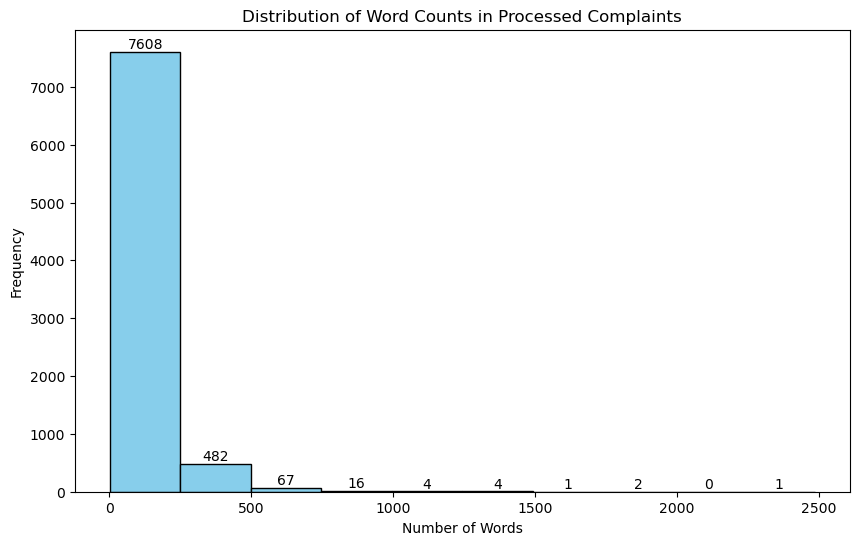

In [4]:
import pandas as pd
import matplotlib.pyplot as plt



# Calculate the number of words in each complaint
ds['Word Count'] = ds['Processed Complaint'].apply(lambda x: len(x.split()))

# Plot histogram
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(ds['Word Count'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Word Counts in Processed Complaints')

# Adding frequency labels on top of each bar
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width() / 2, 
             n[i], 
             int(n[i]), 
             ha='center', 
             va='bottom')

plt.show()


In [5]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import hdbscan
import numpy as np
import pandas as pd
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [6]:
# Function to calculate a basic topic diversity score
def calculate_topic_diversity(topic_model):
    unique_words = set()
    total_words = 0
    for topic in topic_model.get_topics().values():
        words = [word for word, _ in topic]  # Extract top words
        unique_words.update(words)
        total_words += len(words)
    diversity_score = len(unique_words) / total_words
    return diversity_score
# Function to calculate coherence score
def calculate_coherence_score(topic_model, texts, dictionary, coherence='c_v'):
    # Extract topics from BERTopic
    topics = [[word for word, _ in topic] for topic in topic_model.get_topics().values()]
    
    # Create a CoherenceModel using extracted topics
    coherence_model = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence=coherence)
    coherence_score = coherence_model.get_coherence()
    return coherence_score

In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.mixture import GaussianMixture
from sentence_transformers import SentenceTransformer
import hdbscan
from bertopic import BERTopic
from gensim.corpora import Dictionary
from transformers import BigBirdTokenizer, BigBirdModel, AutoModel, AutoTokenizer, AutoModelForPreTraining, AutoModelForMaskedLM, ReformerModel, ReformerTokenizer
import torch
from sklearn.decomposition import PCA, TruncatedSVD
from umap import UMAP



In [8]:
# Load and preprocess your dataset
documents = ds['Processed Complaint'].tolist()
print(len(documents))


8185


In [9]:
class GMMWrapper(GaussianMixture): # or regular GaussianMixture
    def fit(self,*args,**kwargs):
        clusters = self.fit_predict(*args,**kwargs)
        
        # get rid of empty clusters
        cluster_map = -100*np.ones(clusters.max()+1)
        cluster_ids_unique = np.unique(clusters)
        cluster_map[cluster_ids_unique] = np.arange(len(cluster_ids_unique))
        clusters_new = cluster_map[clusters]

        # save it in labels attribute
        self.labels_ = clusters_new
        return self

In [10]:
# Define different embedding models
embedding_models = {
    "TF-IDF": TfidfVectorizer(),
    "BERT": SentenceTransformer('all-MiniLM-L6-v2'),
    "DistilBERT": SentenceTransformer('distilbert-base-nli-mean-tokens'),
    "ALBERT": AutoModel.from_pretrained("albert-base-v1"),
    "BigBird": AutoModelForPreTraining.from_pretrained("google/bigbird-roberta-base"),
    "Longformer": AutoModel.from_pretrained("allenai/longformer-base-4096")
}
# Define dimensionality reduction models
dimension_reducers = {
    "PCA": PCA(n_components=5),
    "UMAP": UMAP(n_components=5),
    "TruncatedSVD": TruncatedSVD(n_components=5)
}

# Initialize an Excel writer to save results
results = {}
with pd.ExcelWriter("topic_modeling_model_tunning.xlsx") as writer:
    summary_df_head = pd.DataFrame(columns=["Embedding Model", "Dimensionality Reduction", "Clustering Method", 
                                       "Number of Topics", "Topic Diversity Score", "Coherence Score", "Total Score"])
    summary_df_head.to_excel(writer, sheet_name="Summary", index=False)
    i=0;
    # Iterate over each embedding model
    for embed_name, embed_model in embedding_models.items():
        print(f"\nTesting with Embedding: {embed_name}")

        for reducer_name, reducer in dimension_reducers.items():
            print(f"  Applying Dimensionality Reduction: {reducer_name}")
        # Apply custom clustering algorithms
            for cluster_name in ["HDBSCAN", "AgglomerativeClustering", "DBSCAN", "SpectralClustering","GaussianMixture","KMeans"]:
                print(f"  Using Clustering: {cluster_name}")
                i=i+1
                # Configure clustering model for BERTopic
                if cluster_name == "HDBSCAN":
                    cluster_model = hdbscan.HDBSCAN(min_cluster_size=10, metric='euclidean')
                elif cluster_name == "AgglomerativeClustering":
                    cluster_model = AgglomerativeClustering(n_clusters=10, metric='euclidean', linkage='ward')
                elif cluster_name == "DBSCAN":
                    cluster_model = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
                elif cluster_name == "SpectralClustering":
                    cluster_model = SpectralClustering(n_clusters=10, affinity='nearest_neighbors')
                elif cluster_name == "GaussianMixture":
                    cluster_model = GMMWrapper(n_components=10,covariance_type='full')
                elif cluster_name == "KMeans": 
                    cluster_model = KMeans(n_clusters=10)
            
                # Initialize BERTopic with embedding model and clustering model
                topic_model = BERTopic(embedding_model=embed_model, hdbscan_model=cluster_model,umap_model=reducer)
                topics, _ = topic_model.fit_transform(documents)

                # Retrieve topic information and calculate diversity score
                topic_info = topic_model.get_topic_info()
                topic_diversity = calculate_topic_diversity(topic_model)

                # Prepare data for coherence score calculation
                tokenized_documents = [doc.split() for doc in documents]  # Tokenize documents
                dictionary = Dictionary(tokenized_documents)  # Create dictionary for Gensim
                # Calculate coherence score
                coherence_score = calculate_coherence_score(topic_model, tokenized_documents, dictionary)

                # Print the number of topics
                num_topics = topic_info.shape[0]  # Number of topics is the number of rows in topic_info
                results[(embed_name, cluster_name)] = {
                "topic_diversity": topic_diversity,
                "topic_info": topic_info,
                "coherence_score": coherence_score
                }

                # Create a summary DataFrame for the current iteration
                summary_df = pd.DataFrame({
                "Embedding Model": [embed_name],
                "Dimensionality Reduction": [reducer_name],
                "Clustering Method": [cluster_name],
                "Number of Topics": [num_topics],
                "Topic Diversity Score": [topic_diversity],
                "Coherence Score": [coherence_score],
                "total Score":[topic_diversity + coherence_score]
                })

                # Write the summary to a specific sheet
                sheet_name_0 = "Summary"
                summary_df.to_excel(writer, sheet_name="Summary", startrow=i , index=False, header=False)
                sheet_name = f"{embed_name}_{cluster_name}_{reducer_name}"
                summary_df.to_excel(writer, sheet_name=sheet_name, index=False)

                # Convert topic_info to a DataFrame and write it to the same sheet
                topic_info_df = pd.DataFrame(topic_info)  # Ensure topic_info is a DataFrame
                topic_info_df.to_excel(writer, sheet_name=sheet_name, startrow=len(summary_df) + 2, index=False)

                # Optionally, add a header for the topic information section
                worksheet = writer.sheets[sheet_name]
                worksheet.cell(row=len(summary_df) + 2, column=1, value="Topic Information:")

print("Results have been saved to 'topic_modeling_model_tunning.xlsx'")



Testing with Embedding: TF-IDF
  Applying Dimensionality Reduction: PCA
  Using Clustering: HDBSCAN
  Using Clustering: AgglomerativeClustering
  Using Clustering: DBSCAN
  Using Clustering: SpectralClustering
  Using Clustering: GaussianMixture
  Using Clustering: KMeans
  Applying Dimensionality Reduction: UMAP
  Using Clustering: HDBSCAN
  Using Clustering: AgglomerativeClustering
  Using Clustering: DBSCAN
  Using Clustering: SpectralClustering
  Using Clustering: GaussianMixture
  Using Clustering: KMeans
  Applying Dimensionality Reduction: TruncatedSVD
  Using Clustering: HDBSCAN
  Using Clustering: AgglomerativeClustering
  Using Clustering: DBSCAN
  Using Clustering: SpectralClustering
  Using Clustering: GaussianMixture
  Using Clustering: KMeans

Testing with Embedding: BERT
  Applying Dimensionality Reduction: PCA
  Using Clustering: HDBSCAN
  Using Clustering: AgglomerativeClustering
  Using Clustering: DBSCAN
  Using Clustering: SpectralClustering
  Using Clustering: Gau